# UIUC Grid Demand with Echo State Networks

This notebook uses an Echo State Network(ESN) (from ``pyESN``) to predict
the demand at the University of Illinois.

The following items are included:
1. An initial demonstration of the ESN with a 72-hour prediction.
2. Grid optimization over spectral radius and noise
3. Grid optimization over reservoir size and sparsity
4. Demonstrate the effect of training length on accuracy.
5. A final demonstration of the ESN with optimized hyper-parameters.

### 1. Initial Demonstration

In [73]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom libraries
from tools import MSE
from pyESN.pyESN import ESN

In [2]:
# import demand data
dataframe = pd.read_csv("data/uiuc_demand_data.csv", usecols=['time','kw'])
demand = np.array(dataframe.kw).astype('float64')

# normalize
norm = np.linalg.norm(demand)
demand_norm = demand/norm

In [19]:
n_reservoir= 1000
sparsity=0.1
rand_seed=85
spectral_radius = 1.5
# for regularization
noise = .0001


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 8000
futureTotal=72
pred_tot=np.zeros(futureTotal)

# train the ESN
pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal:-futureTotal])
demand_pred = esn.predict(np.ones(futureTotal))

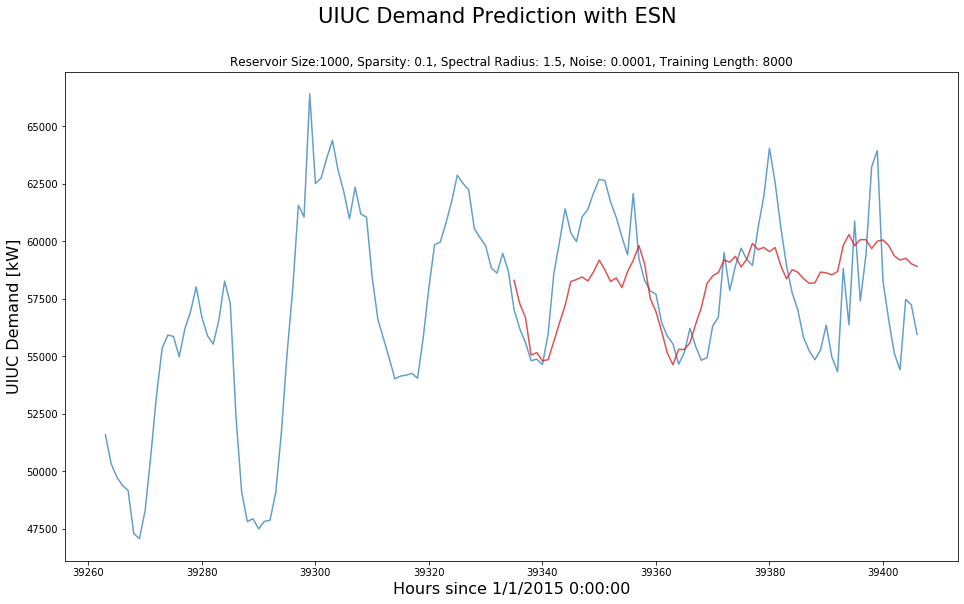

In [24]:
time = np.arange(0,len(time),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2015 0:00:00", fontsize=16)

# plot the truth
plt.plot(time[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time[-futureTotal:], norm*demand_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

### 2. Grid Optimization Over Spectral Radius and Noise

In [33]:
n_reservoir= 1000
sparsity=0.1
rand_seed=85

radius_set = [0.5, 0.7, 0.9,  1,  1.1,1.3,1.5]
noise_set = [ 0.0001, 0.0003,0.0007, 0.001, 0.003, 0.005, 0.007,0.01]

radius_set_size  = len(radius_set)
noise_set_size = len(noise_set)

trainlen = 8000
future = 1
futureTotal= 72

loss = np.zeros([radius_set_size, noise_set_size])

for l in range(radius_set_size):
    rho = radius_set[l]
    for j in range(noise_set_size):
        noise = noise_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
              n_outputs = 1, 
              n_reservoir = n_reservoir,
              sparsity=sparsity,
              random_state=rand_seed,
              spectral_radius = rho,
              noise=noise)

        pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal:-futureTotal])
        demand_pred = esn.predict(np.ones(futureTotal))
        
        loss[l, j] = MSE(demand_pred, demand_norm[-futureTotal:])        
        print('rho = ', radius_set[l], ', noise = ', noise_set[j], ', MSE = ', loss[l][j] )

rho =  0.5 , noise =  0.0001 , MSE =  0.0005147263141197072
rho =  0.5 , noise =  0.0003 , MSE =  0.00048782443148997053
rho =  0.5 , noise =  0.0007 , MSE =  0.00043891658035080856
rho =  0.5 , noise =  0.001 , MSE =  0.00041239164021295835
rho =  0.5 , noise =  0.003 , MSE =  0.00039527190440892486
rho =  0.5 , noise =  0.005 , MSE =  0.0004923327765743809
rho =  0.5 , noise =  0.007 , MSE =  0.0006286663293363784
rho =  0.5 , noise =  0.01 , MSE =  0.0008147778812596353
rho =  0.7 , noise =  0.0001 , MSE =  0.000446306327416837
rho =  0.7 , noise =  0.0003 , MSE =  0.00047115279003267347
rho =  0.7 , noise =  0.0007 , MSE =  0.000448866618573525
rho =  0.7 , noise =  0.001 , MSE =  0.00042857295016230154
rho =  0.7 , noise =  0.003 , MSE =  0.0004122260217376514
rho =  0.7 , noise =  0.005 , MSE =  0.0005270171489407264
rho =  0.7 , noise =  0.007 , MSE =  0.0006793164545735355
rho =  0.7 , noise =  0.01 , MSE =  0.0008718309230689563
rho =  0.9 , noise =  0.0001 , MSE =  0.00032488

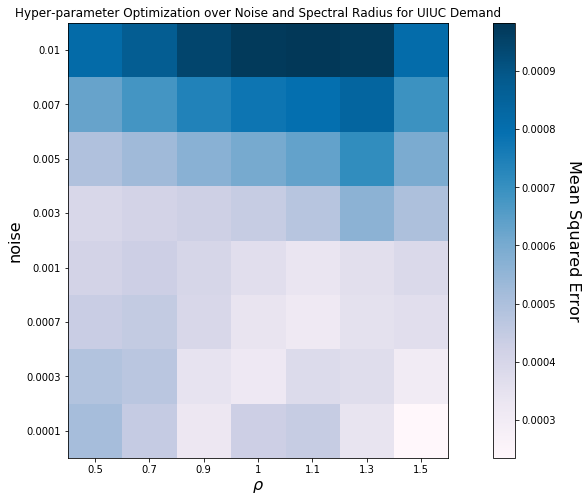

In [36]:
plt.figure(figsize=(16,8))
plt.title("Hyper-parameter Optimization over Noise and Spectral Radius for UIUC Demand")
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuBu')
plt.xticks(np.linspace(0,radius_set_size-1,radius_set_size), radius_set);
plt.yticks(np.linspace(0,noise_set_size-1, noise_set_size), noise_set);
plt.xlabel(r'$\rho$', fontsize=16); plt.ylabel('noise', fontsize=16); 
# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 
cb.set_label(label="Mean Squared Error", fontsize=16, rotation=-90, labelpad=25);

In [35]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
rho_opt = radius_set[int(index_min[0])]
noise_opt = noise_set[int(index_min[1])]
print('The optimal set is:\nspectrum radius = ',
      rho_opt,'\nnoise = ',noise_opt,'\nMSE = ',minLoss)

The optimal set is:
spectrum radius =  1.5 
noise =  0.0001 
MSE =  0.00023523853822208683


### 3. Grid Optimization Over Reservoir Size and Sparsity

The algorithm is unstable when ``n_reservoir == trainlen``.

In [40]:
rho = 1.5
noise = 0.0001
rand_seed=85

reservoir_set = [600, 800, 1000, 1500, 2000, 3000, 4000]
sparsity_set = [0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

reservoir_set_size  = len(reservoir_set)
sparsity_set_size = len(sparsity_set)

trainlen = 8000
future = 1
futureTotal= 72

loss = np.zeros([reservoir_set_size, sparsity_set_size])

for l in range(reservoir_set_size):
    n_reservoir = reservoir_set[l]
    for j in range(sparsity_set_size):
        sparsity = sparsity_set[j]

        pred_tot=np.zeros(futureTotal)

        esn = ESN(n_inputs = 1,
              n_outputs = 1, 
              n_reservoir = n_reservoir,
              sparsity=sparsity,
              random_state=rand_seed,
              spectral_radius = rho,
              noise=noise)

        pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal:-futureTotal])
        demand_pred = esn.predict(np.ones(futureTotal))
        
        loss[l, j] = MSE(demand_pred, demand_norm[-futureTotal:])        
        print('n_reservoir = ', reservoir_set[l], ', sparsity = ', sparsity_set[j], ', MSE = ', loss[l][j] )

n_reservoir =  600 , sparsity =  0.005 , MSE =  0.00023224249593620008
n_reservoir =  600 , sparsity =  0.01 , MSE =  0.00029839790086802655
n_reservoir =  600 , sparsity =  0.03 , MSE =  0.00021692198582000697
n_reservoir =  600 , sparsity =  0.05 , MSE =  0.00022308582000295782
n_reservoir =  600 , sparsity =  0.1 , MSE =  0.00027976336031970076
n_reservoir =  600 , sparsity =  0.15 , MSE =  0.00034502567658919526
n_reservoir =  600 , sparsity =  0.2 , MSE =  0.00029453369071737276
n_reservoir =  800 , sparsity =  0.005 , MSE =  0.00023266980860584495
n_reservoir =  800 , sparsity =  0.01 , MSE =  0.00024151162806411422
n_reservoir =  800 , sparsity =  0.03 , MSE =  0.00020944053187513397
n_reservoir =  800 , sparsity =  0.05 , MSE =  0.0002091278226941783
n_reservoir =  800 , sparsity =  0.1 , MSE =  0.00022613150728303428
n_reservoir =  800 , sparsity =  0.15 , MSE =  0.00026297320602901314
n_reservoir =  800 , sparsity =  0.2 , MSE =  0.00023801926787799787
n_reservoir =  1000 , s

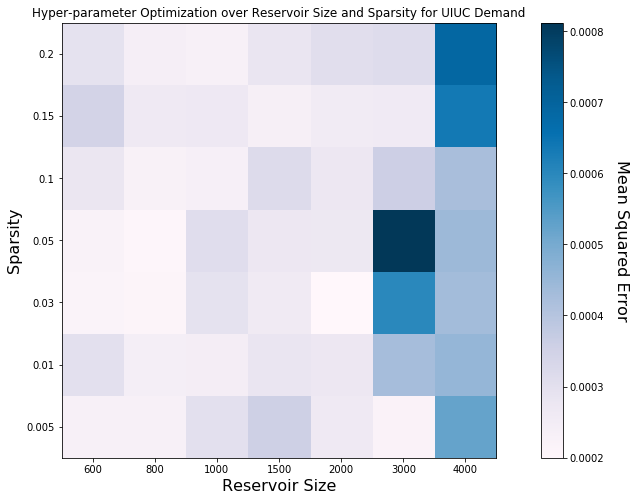

In [45]:
plt.figure(figsize=(16,8))
plt.title("Hyper-parameter Optimization over Reservoir Size and Sparsity for UIUC Demand")
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuBu')
plt.xticks(np.linspace(0,reservoir_set_size-1,reservoir_set_size), reservoir_set);
plt.yticks(np.linspace(0,sparsity_set_size-1, sparsity_set_size), sparsity_set);
plt.xlabel(r'Reservoir Size', fontsize=16); plt.ylabel('Sparsity', fontsize=16); 
# im.set_interpolation('bilinear')
cb = plt.colorbar(im); 
cb.set_label(label="Mean Squared Error", fontsize=16, rotation=-90, labelpad=25);

In [47]:
minLoss = np.min(loss)
index_min = np.where(loss == minLoss)
index_min
n_opt = reservoir_set[int(index_min[0])]
s_opt = sparsity_set[int(index_min[1])]
print('The optimal set is:\nreservoir_size = ',
      n_opt,'\nsparsity = ',s_opt,'\nMSE = ',minLoss)

The optimal set is:
reservoir_size =  2000 
sparsity =  0.03 
MSE =  0.00019967344738370998


### 4. Demonstrate the Effect of Training Length

Once again, the algorithm is unstable when ``n_reservoir == trainlen``.

We should expect that MSE will decrease as training length increases.

In [53]:
# optimal set of n_reservoir and sparsity
n_reservoir= 2000
sparsity=0.03

# optimal set of spectral_radius and noise
spectral_radius = 1.5
# for regularization
noise = .0001

rand_seed=85

trainingLengths = np.arange(4000,25000,300)
futureTotal=72

loss_k = np.zeros(len(trainingLengths))

for l in range(len(trainingLengths)):
    trainlen = trainingLengths[l]   

    esn = ESN(n_inputs = 1,
          n_outputs = 1, 
          n_reservoir = n_reservoir,
          sparsity=sparsity,
          random_state=rand_seed,
          spectral_radius = spectral_radius,
          noise=noise)


    pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal:-futureTotal])
    demand_pred = esn.predict(np.ones(futureTotal))
        
    loss_k[l] = MSE(demand_pred, demand_norm[-futureTotal:]) 
    
    print(f"Training length = {trainlen}, MSE = {loss_k[l]}")

Training length = 4000, MSE = 0.0006787466893412016
Training length = 4300, MSE = 0.0006198836280293635
Training length = 4600, MSE = 0.0006670760339399106
Training length = 4900, MSE = 0.0004800996664881757
Training length = 5200, MSE = 0.00041564257429987055
Training length = 5500, MSE = 0.0004117699925699248
Training length = 5800, MSE = 0.00031976766707893966
Training length = 6100, MSE = 0.0002921778126329372
Training length = 6400, MSE = 0.0002656203281849534
Training length = 6700, MSE = 0.0006068217849040268
Training length = 7000, MSE = 0.0009745415450263664
Training length = 7300, MSE = 0.0004898255884503885
Training length = 7600, MSE = 0.0002775155956097815
Training length = 7900, MSE = 0.0002834929786033538
Training length = 8200, MSE = 0.0002717920645408323
Training length = 8500, MSE = 0.0006612167933040435
Training length = 8800, MSE = 0.00039001019421366803
Training length = 9100, MSE = 0.0004585343379831804
Training length = 9400, MSE = 0.00041389147850719795
Training

Text(0, 0.5, 'MSE')

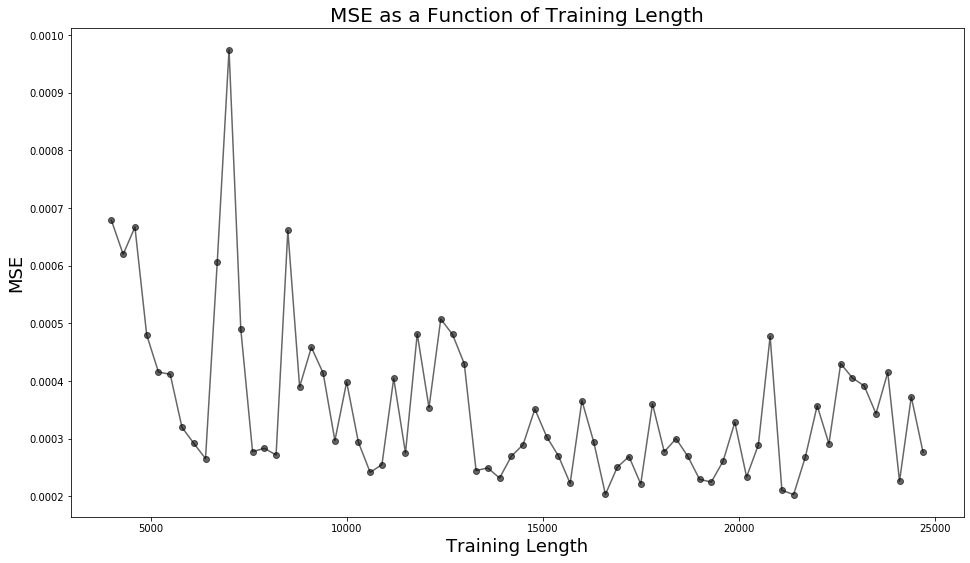

In [54]:
plt.figure(figsize=(16,9))
plt.plot(trainingLengths, loss_k,'-ok', alpha=0.6)
plt.title('MSE as a Function of Training Length', fontsize=20)
plt.xlabel('Training Length', fontsize=18)
plt.ylabel('MSE', fontsize=18)

In [56]:
minloss = np.min(loss_k)
index_min = np.where(loss_k == minloss)
l_opt = trainingLengths[index_min]

print(f"Training length with minimum error was: {l_opt}")

Training length with minimum error was: [21400]


### Further Questions

- What about overfitting?
- What would overfitting look like for a model like this?

In [57]:
n_reservoir= 2000
sparsity=0.03
rand_seed=85
spectral_radius = 1.5
# for regularization
noise = .0001


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 21400
futureTotal=72
pred_tot=np.zeros(futureTotal)

# train the ESN
pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal:-futureTotal])
demand_pred = esn.predict(np.ones(futureTotal))

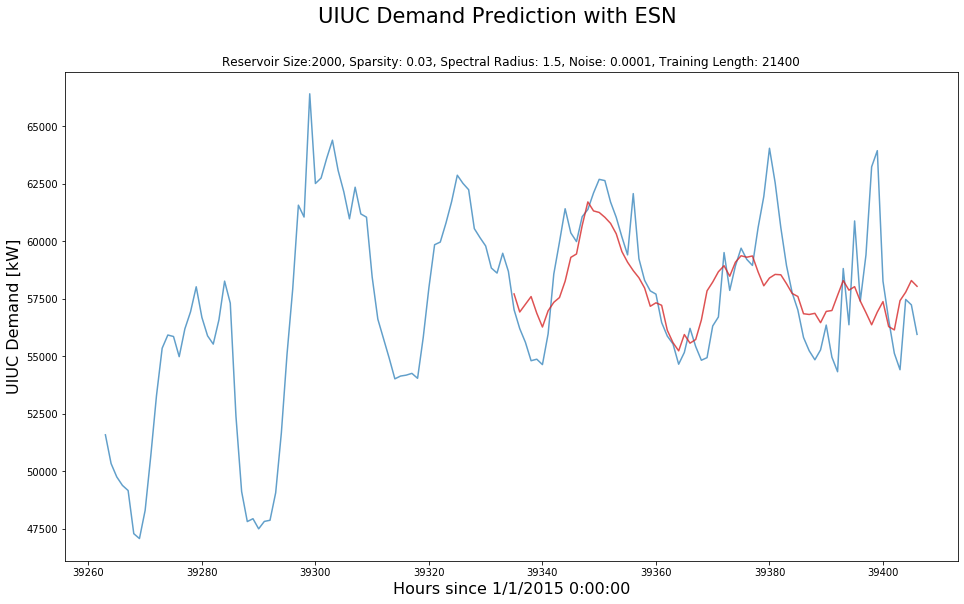

In [58]:
time = np.arange(0,len(time),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2015 0:00:00", fontsize=16)

# plot the truth
plt.plot(time[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time[-futureTotal:], norm*demand_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [60]:
# loss_k[:10]
trainingLengths[8]

6400

In [61]:
n_reservoir= 2000
sparsity=0.03
rand_seed=85
spectral_radius = 1.5
# for regularization
noise = .0001


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 6400
futureTotal=72
pred_tot=np.zeros(futureTotal)

# train the ESN
pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal:-futureTotal])
demand_pred = esn.predict(np.ones(futureTotal))

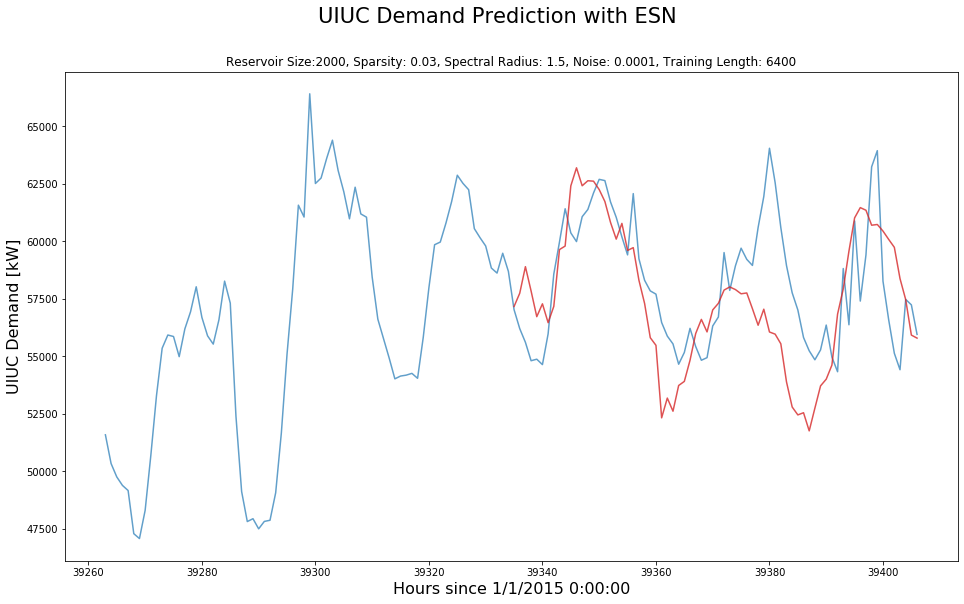

In [62]:
time = np.arange(0,len(time),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2015 0:00:00", fontsize=16)

# plot the truth
plt.plot(time[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time[-futureTotal:], norm*demand_pred,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()

In [76]:
tic = time.perf_counter()
n_reservoir= 2000
sparsity=0.03
rand_seed=85
spectral_radius = 1.5
# for regularization
noise = .0001


esn = ESN(n_inputs = 1,
      n_outputs = 1, 
      n_reservoir = n_reservoir,
      sparsity=sparsity,
      random_state=rand_seed,
      spectral_radius = spectral_radius,
      noise=noise)

trainlen = 6400
futureTotal=144
future = 72
pred_tot=np.zeros(futureTotal)

# train the ESN
for i in range(0,futureTotal, future):
    pred_training = esn.fit(np.ones(trainlen),demand_norm[-trainlen-futureTotal-i:-futureTotal-i])
    prediction = esn.predict(np.ones(future))
    pred_tot[i:i+future] = prediction[:,0]
    
toc = time.perf_counter()
elapsed = toc - tic
print(f"This simulation took {elapsed:0.02f} seconds")
print(f"This simulation took {elapsed/60:0.02f} minutes")

This simulation took 28.87 seconds
This simulation took 0.48 minutes


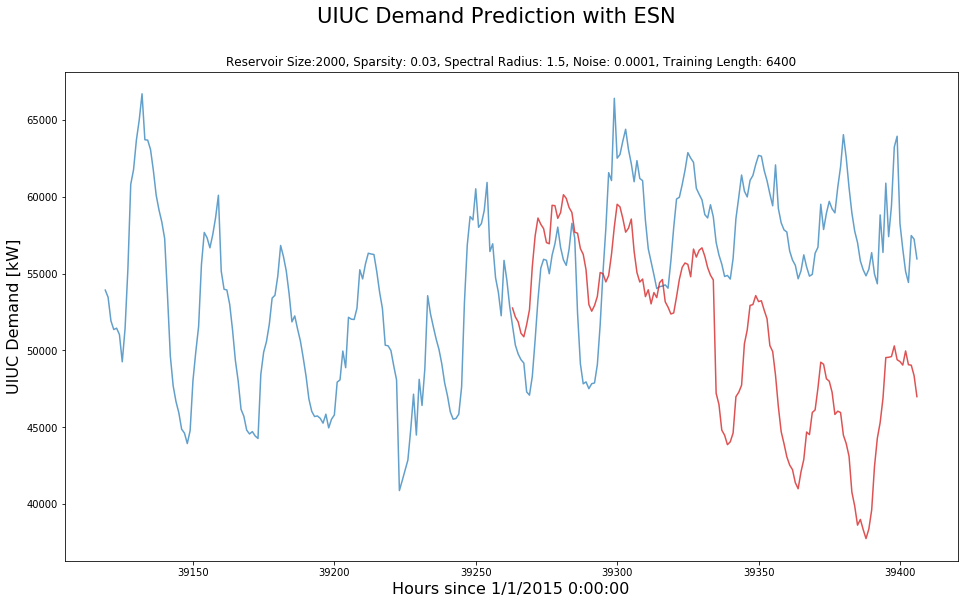

In [80]:
time_range = np.arange(0,len(demand_norm),1)

plt.figure(figsize=(16,9))
plt.suptitle("UIUC Demand Prediction with ESN", fontsize=21)
plt.title(f"Reservoir Size:{n_reservoir}, Sparsity: {sparsity}, Spectral Radius: {spectral_radius}, Noise: {noise}, Training Length: {trainlen}")
plt.ylabel("UIUC Demand [kW]", fontsize=16)
plt.xlabel("Hours since 1/1/2015 0:00:00", fontsize=16)

# plot the truth
plt.plot(time_range[-2*futureTotal:],norm*demand_norm[-2*futureTotal:],'b',label="True Demand", 
         alpha=0.7,
         color='tab:blue')
# # plot the prediction
plt.plot(time_range[-futureTotal:], norm*pred_tot,  alpha=0.8, 
         label='ESN Prediction',
         color='tab:red',
         linestyle='-')
plt.legend()